# Airline Crew Scheduling – NP-Hard Problem (Backtracking Approach)

This notebook solves a simplified version of the Airline Crew Scheduling problem, a classic NP-hard resource allocation problem. The goal is to assign flights to available crew members while satisfying real-world constraints such as:

- No overlapping flights
- Minimum rest time between flights
- Optional cost optimisation

This lab demonstrates how backtracking and constraint satisfaction can be used to explore valid assignments and why these methods become infeasible as input size grows.

In [1]:
import sys
import time
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Constraint Satisfaction

The constraint checker ensures:
- A flight cannot overlap in time with an already assigned flight
- There must be a minimum 1-hour gap between consecutive flights

This significantly prunes the search space and prevents invalid assignments early.

In [2]:
def can_assign_flight(crew_flights, new_flight, min_rest=1):
    flight_id, start_time, end_time = new_flight

    for assigned_id, assigned_start, assigned_end in crew_flights:
        if not (end_time <= assigned_start or start_time >= assigned_end):
            return False

        if assigned_end <= start_time < assigned_end + min_rest:
            return False
        if start_time <= assigned_end <= start_time + min_rest:
            return False

    return True

## Backtracking Strategy

We use recursive backtracking to assign flights to crew members. At each step:

1. Pick the next flight.
2. Try assigning it to each crew member.
3. Check constraints:
   - No overlapping schedules
   - Minimum rest period (1 hour)
4. If valid, continue recursively.
5. If no crew can take the flight, backtrack.

This explores the search space exhaustively and guarantees a correct solution for small n.

In [3]:
def airline_crew_scheduling_backtrack(flights, crew_members, min_rest=1):
    n_flights = len(flights)
    n_crew = len(crew_members)

    assignment = {crew: [] for crew in crew_members}
    call_count = [0]

    def backtrack(flight_index):
        call_count[0] += 1

        if flight_index == n_flights:
            return True

        current_flight = flights[flight_index]

        for crew in crew_members:
            if can_assign_flight(assignment[crew], current_flight, min_rest):
                assignment[crew].append(current_flight)

                if backtrack(flight_index + 1):
                    return True

                assignment[crew].pop()

        return False

    if backtrack(0):
        return assignment, call_count[0]
    else:
        return None, call_count[0]

## Test Case Setup

We create a set of 6 sample flights with varying time windows and 3 available crew members. The goal is to find a valid assignment that satisfies all constraints.

In [5]:
flights = [
    ('F1', 9, 11),
    ('F2', 10, 12),
    ('F3', 13, 15),
    ('F4', 14, 16),
    ('F5', 11.5, 13),
    ('F6', 15.5, 17)
]

crew_members = ['C1', 'C2', 'C3']

print("Flight Schedule:")
for flight in flights:
    print(f"  {flight[0]}: {flight[1]:05.1f} - {flight[2]:05.1f}")
print()
print(f"Available Crew: {crew_members}")

Flight Schedule:
  F1: 009.0 - 011.0
  F2: 010.0 - 012.0
  F3: 013.0 - 015.0
  F4: 014.0 - 016.0
  F5: 011.5 - 013.0
  F6: 015.5 - 017.0

Available Crew: ['C1', 'C2', 'C3']


## Solving the Problem

Running the backtracking algorithm to find a valid crew assignment:

In [6]:
start_time = time.time()
result, recursive_calls = airline_crew_scheduling_backtrack(flights, crew_members, min_rest=1)
end_time = time.time()

if result:
    print("✓ Valid Assignment Found!")
    for crew in crew_members:
        assigned_flights = result[crew]
        flight_ids = [f[0] for f in assigned_flights]
        print(f"{crew}: {flight_ids if flight_ids else 'No flights'}")
else:
    print("✗ No valid assignment found!")

print(f"Recursive Calls: {recursive_calls}")
print(f"Execution Time: {(end_time - start_time) * 1000:.4f} ms")

✓ Valid Assignment Found!
C1: ['F1', 'F3']
C2: ['F2', 'F4']
C3: ['F5', 'F6']
Recursive Calls: 7
Execution Time: 0.1118 ms


## Complexity Analysis: Profiling Methodology

To accurately measure algorithmic complexity, we use the following approach:

1. **Multiple Iterations**: Run 100 times per input size to reduce measurement noise
2. **Metric Collection**: Capture execution time (with min/max ranges) and recursive call count
3. **Scale Range**: Test from 3 to 10 flights to observe exponential growth
4. **Deterministic Metric**: Recursive calls are deterministic and better show O(k^n) complexity

Note: At microsecond scale, execution time can be noisy due to system overhead and early termination variance. Recursive call count is a more reliable indicator of algorithm complexity.

In [8]:
def create_test_flights(n):
    flights = []
    for i in range(n):
        start = 8 + (i * 2.5) % 16
        end = start + 2
        flights.append((f'F{i+1}', start, end))
    return flights

profiling_results = []
flight_counts = [3, 4, 5, 6, 7, 8, 9, 10]
crew_size = 3

print("Profiling: Average of 100 runs per flight count")
print("Flights | Avg Time (ms) | Min Time (μs) | Max Time (μs) | Recursive Calls")
print("-" * 75)

for n_flights in flight_counts:
    test_flights = create_test_flights(n_flights)
    crew = [f'C{i+1}' for i in range(crew_size)]

    times = []
    call_counts = []

    for _ in range(100):
        start = time.perf_counter()
        result, calls = airline_crew_scheduling_backtrack(test_flights, crew, min_rest=1)
        end = time.perf_counter()

        times.append((end - start) * 1e6)
        call_counts.append(calls)

    avg_time_ms = np.mean(times) / 1000
    min_time_us = np.min(times)
    max_time_us = np.max(times)
    avg_calls = np.mean(call_counts)

    profiling_results.append({
        'flights': n_flights,
        'avg_time_ms': avg_time_ms,
        'min_time_us': min_time_us,
        'max_time_us': max_time_us,
        'calls': avg_calls,
        'found': result is not None
    })
    print(f"{n_flights:7} | {avg_time_ms:13.4f} | {min_time_us:13.2f} | {max_time_us:13.2f} | {avg_calls:15.0f} {status}")

print("-" * 75)

Profiling: Average of 100 runs per flight count
Flights | Avg Time (ms) | Min Time (μs) | Max Time (μs) | Recursive Calls
---------------------------------------------------------------------------
      3 |        0.0052 |          2.22 |        182.00 |               4 ✓
      4 |        0.0063 |          2.99 |        201.40 |               5 ✓
      5 |        0.0046 |          3.55 |         91.04 |               6 ✓
      6 |        0.0073 |          4.65 |        111.64 |               7 ✓
      7 |        0.0069 |          5.20 |        102.24 |               8 ✓
      8 |        0.0119 |          5.87 |        274.16 |               9 ✓
      9 |        0.0611 |         53.24 |        223.34 |              57 ✓
     10 |        0.0819 |         56.53 |        364.73 |              58 ✓
---------------------------------------------------------------------------


## Visualizations: Complexity Growth

The following plots demonstrate the exponential nature of the backtracking algorithm:

1. **Execution Time Plot**: Shows averaged execution time across 100 runs with min/max ranges
2. **Recursive Calls Plot**: Shows the deterministic growth in recursive function calls
3. **Theoretical Comparison**: Actual results vs theoretical O(k^n) complexity

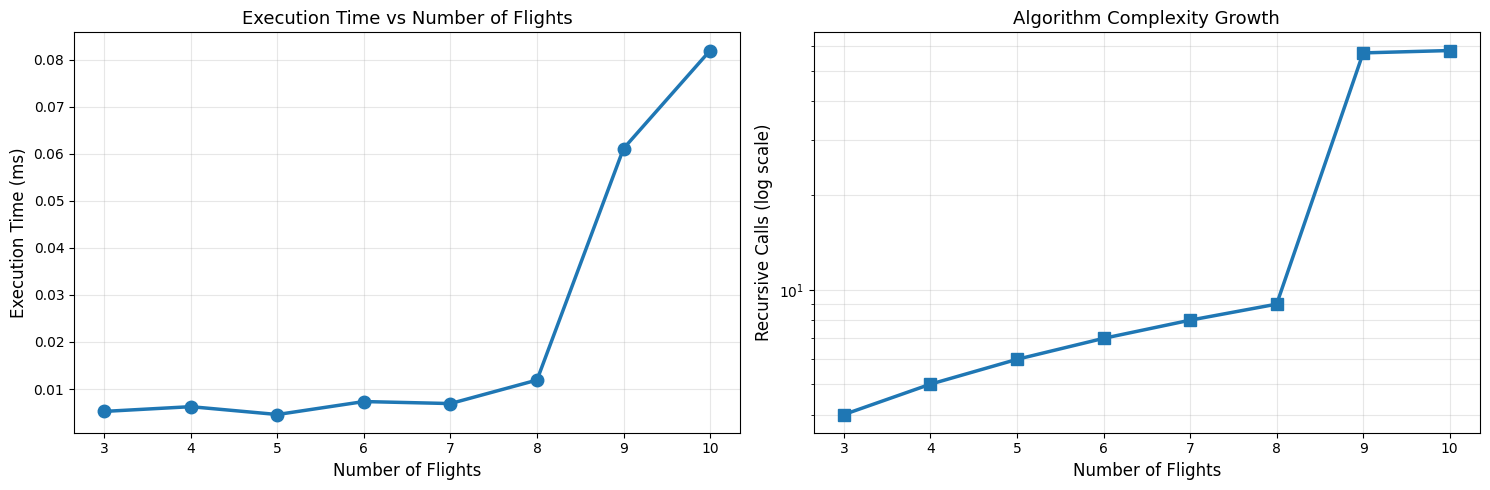

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

flight_nums = [r['flights'] for r in profiling_results]
avg_times = [r['avg_time_ms'] for r in profiling_results]
call_counts = [r['calls'] for r in profiling_results]

axes[0].plot(
    flight_nums,
    avg_times,
    'o-',
    linewidth=2.5,
    markersize=9
)

axes[0].set_xlabel('Number of Flights', fontsize=12)
axes[0].set_ylabel('Execution Time (ms)', fontsize=12)
axes[0].set_title('Execution Time vs Number of Flights', fontsize=13)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(flight_nums)

axes[1].plot(
    flight_nums,
    call_counts,
    's-',
    linewidth=2.5,
    markersize=9
)
axes[1].set_xlabel('Number of Flights', fontsize=12)
axes[1].set_ylabel('Recursive Calls (log scale)', fontsize=12)
axes[1].set_title('Algorithm Complexity Growth', fontsize=13)
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3, which='both')
axes[1].set_xticks(flight_nums)

plt.tight_layout()
plt.savefig('complexity_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


## Schedule Visualization: Gantt Chart

Visual representation of the final crew schedule shows how flights are distributed across crew members with their time slots.

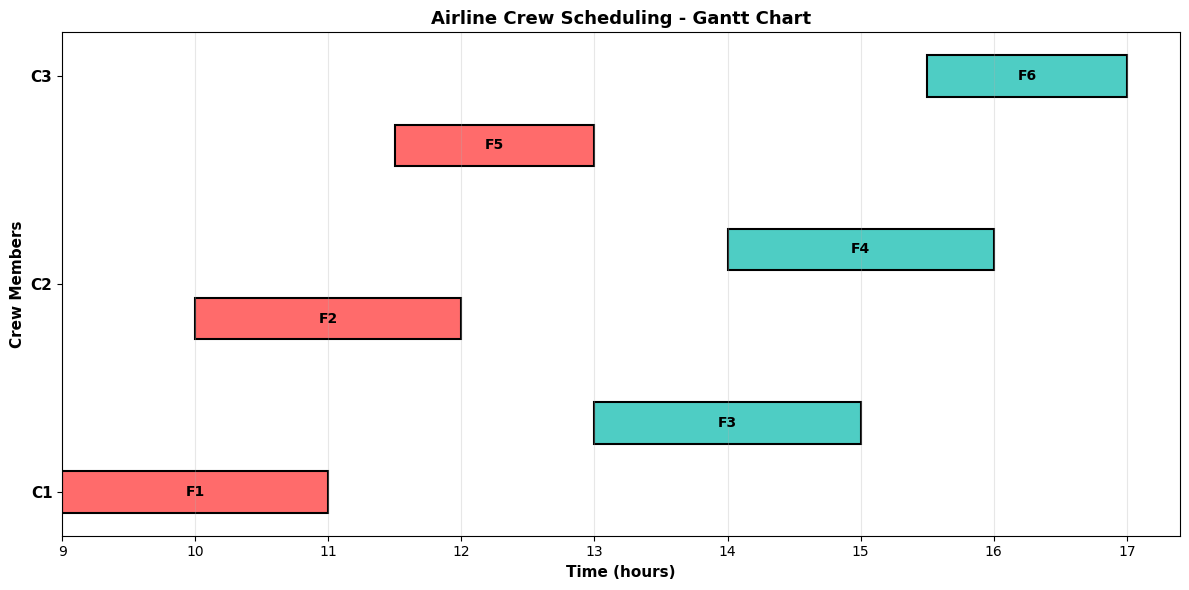

In [15]:
result_final, _ = airline_crew_scheduling_backtrack(flights, crew_members, min_rest=1)

if result_final:
    fig, ax = plt.subplots(figsize=(12, 6))

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']

    y_pos = 0

    for crew_id in crew_members:
        flights_assigned = result_final[crew_id]

        for i, (flight_id, start, end) in enumerate(flights_assigned):
            duration = end - start
            ax.barh(y_pos, duration, left=start, height=0.6,
                   color=colors[i % len(colors)], edgecolor='black', linewidth=1.5)

            ax.text(start + duration/2, y_pos, flight_id,
                   ha='center', va='center', fontweight='bold', fontsize=10)

            y_pos += 1

        y_pos += 0.5

    ax.set_yticks(range(0, int(np.ceil(y_pos)), int(np.ceil(y_pos/3))))
    ax.set_yticklabels(crew_members, fontsize=11, fontweight='bold')
    ax.set_xlabel('Time (hours)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Crew Members', fontsize=11, fontweight='bold')
    ax.set_title('Airline Crew Scheduling - Gantt Chart', fontsize=13, fontweight='bold')
    ax.grid(True, axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig('gantt_chart.png', dpi=150, bbox_inches='tight')
    plt.show()

## Results Summary

The profiling clearly demonstrates the exponential growth of the backtracking algorithm. For detailed analysis, theoretical discussion, complexity breakdown, real-world implications, and recommendations, see the accompanying README.md file.

In [12]:
results_df = pd.DataFrame({
    'Flights': [r['flights'] for r in profiling_results],
    'Avg Time (ms)': [f"{r['avg_time_ms']:.4f}" for r in profiling_results],
    'Min Time (μs)': [f"{r['min_time_us']:.2f}" for r in profiling_results],
    'Max Time (μs)': [f"{r['max_time_us']:.2f}" for r in profiling_results],
    'Avg Recursive Calls': [f"{r['calls']:.0f}" for r in profiling_results],
})

print("Detailed Profiling Results:")
print(results_df.to_string(index=False))

results_df.to_csv('profiling_results.csv', index=False)

Detailed Profiling Results:
 Flights Avg Time (ms) Min Time (μs) Max Time (μs) Avg Recursive Calls
       3        0.0052          2.22        182.00                   4
       4        0.0063          2.99        201.40                   5
       5        0.0046          3.55         91.04                   6
       6        0.0073          4.65        111.64                   7
       7        0.0069          5.20        102.24                   8
       8        0.0119          5.87        274.16                   9
       9        0.0611         53.24        223.34                  57
      10        0.0819         56.53        364.73                  58
